In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt
import pylab as pl
import itertools, functools
import random

import warnings 
warnings.filterwarnings('ignore')

# It is a learning notebook for learning Linear and Logistic regressions. Its have written manualy via Numpy and Torch

In [2]:
class LinLogRegression:
    """
    Class for both Linear and Logistic Regressions. It's needed to choose mode - "lin" or "log".
    Linear Regression: multipule regressor with L2-regularization.
        Data: X - standart scaled data with shape (n_features, batch_size), y - target with shape (batch_size)
        Predict: REGRESSOR, float64
    LogistiC regression: binary classificator with L2-regularization.
        Data: X - data with shape (1+n_features, batch_size), bias should be included, y - target with shape (batch_size)
        Predict: CLASSIFICATION, bool 
        
    """  
    def __init__(self, X, y, mode=None):
        if mode:
            self.mode = mode
        else:
            raise ValueError('Choose "lin" or "log" mode')
        self.n_features, self.batch_size = X.shape
        self.X = X
        self.y = y

        self.W = np.array([random.uniform(-1, 1) for i in range(self.batch_size)])
        self.b = 1 
           
    #Sigmoid method, log mode
    def sigmoid(self, X):
        z = np.dot(X, self.W)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, lr=0.01, theta=0.01, epochs=100):
        cost_list = [0] * epochs
        self.theta = theta
        
        for epoch in range(epochs):
            if self.mode == "log":
                #forward
                sigma = self.sigmoid(self.X)
                loss = sigma - self.y
                #backpropagation
                dW = np.dot(self.X.T, loss) + self.theta*self.W / self.batch_size 
                self.W -= lr * dW 
                #logistic loss with +1 and 0 classes
                cost = (-self.y * np.log(sigma) - (1 - self.y) * np.log(1 - sigma)).mean() + ((self.theta/2) * self.W**2).mean() 
            else:
                #forward
                y_pred = self.predict(self.X)
                loss = y_pred - self.y
                #backpropagation
                dW = (2 * (np.dot(self.X.T, loss) + (2 * self.theta * self.W))) / self.batch_size
                db = 2 * np.sum(loss) / self.batch_size
                self.W -= lr * dW
                self.b -= lr * db
                #MSE
                cost = np.sum((((self.X.dot(self.W) + self.b) - self.y) ** 2) / (2*self.batch_size)) 
                
            cost_list[epoch] = cost
  
        return cost_list
    
    def get_weights(self):
        if self.mode == "log":            
            return self.W[1:], self.W[0]
        else:
            return self.W, self.b
    
    def predict(self, X, treshold=0.5):
        if self.mode == "log":
            result = self.sigmoid(X)
            result = result >= treshold
            y_pred = np.zeros(result.shape[0])
            for i in range(len(y_pred)):
                if result[i] == True: 
                    y_pred[i] = 1
                else:
                    continue      
            return y_pred
        else:
            return X.dot(self.W) + self.b

# Let's test logistic part of class!

Here we use dataset with tests of microchips from Anrew Ng's course

In [3]:
data = pd.read_csv('.data/microchip_tests.txt',
header=None, names = ('test1','test2','released'))

X_log = data.iloc[:,:2].values
y_log = data.iloc[:,2].values

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


And now let's look at data vizualization

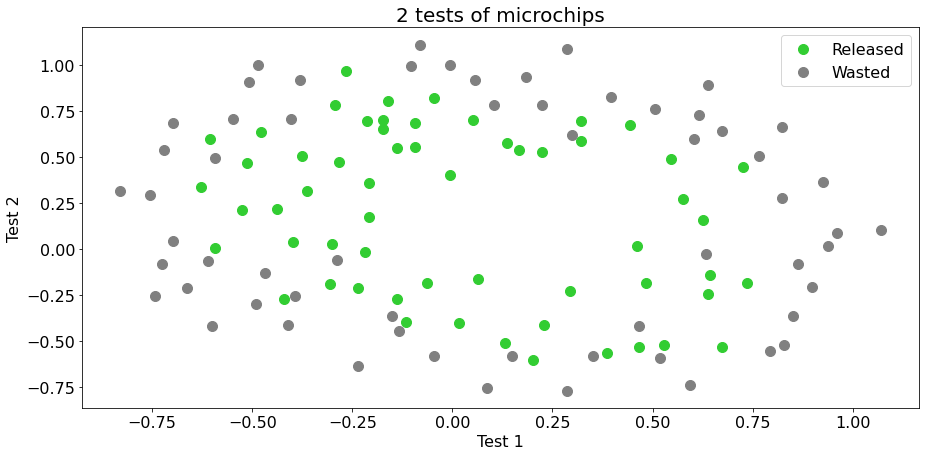

In [4]:
plt.figure(figsize=(15, 7))

plt.scatter(X_log[y_log == 1, 0], X_log[y_log == 1, 1], s=100, c='#32CD32', label='Released')
plt.scatter(X_log[y_log == 0, 0], X_log[y_log == 0, 1], s=100, c='grey', label='Wasted')

plt.xlabel("Test 1", fontsize=16)
plt.ylabel("Test 2", fontsize=16)
plt.title('2 tests of microchips', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

plt.show()

Theare only two features, so we use custom Polynomial Features class to produce more features!

In [5]:
class PolynomialFeatures():
    
    def __init__(self, degree=2):
        self.degree = degree
        
    def n_features(self, X):
        return (self.degree+1)**X[0].shape[0]
        
    def fit_transform(self, X):
        result = np.zeros((X.shape[0], self.n_features(X)))
        for k, i in enumerate(X): #[x1, x2]
            before_comb = []
            for j in i: #x1
                current = []
                for n in range(self.degree+1):
                    current.append(j**n)
                before_comb.append(current)
            one_line_combinations = list(itertools.product(*before_comb))
            one_line = np.array([functools.reduce(lambda a, b : a * b, lst) for lst in one_line_combinations])
            result[k] += one_line
        return result        

In [6]:
poly = PolynomialFeatures(degree=9)
X_log_poly = poly.fit_transform(X_log)

classificator = LinLogRegression(X_log_poly, y_log, mode='log')
cost_list = classificator.fit(0.1, 0.001, 1000)

y_log_pred = classificator.predict(X_log_poly)

print('accuracy -> {}'.format(sum(y_log_pred == y_log) / y_log.shape[0]))

accuracy -> 0.8389830508474576


It works. Bellow we are going to find the best hyperparametrs via Custom Grid Search

In [7]:
params = {'lr': [0.01, 0.001], 'theta': [0.01, 0.001, 0.0001], 
          'epochs': [1000, 2000, 5000, 10000], 'degree': [2, 4, 8, 10]}
best_score = 0
best_classificator = None
best_cost_list = None
for i in range(30):
    current_params = [random.choice(params[param]) for param in params.keys()]
    
    poly = PolynomialFeatures(degree=current_params[3])
    X_log_poly = poly.fit_transform(X_log)

    classificator = LinLogRegression(X_log_poly, y_log, mode='log')
    cost_list = classificator.fit(current_params[0], current_params[1], current_params[2])

    y_log_pred = classificator.predict(X_log_poly)
    accuracy = sum(y_log_pred == y_log) / y_log.shape[0]
    
    if accuracy > best_score:
        best_score = accuracy
        best_params_log = current_params
        best_classificator = classificator
        best_cost_list =  cost_list

print(f"Best accuracy is {round(best_score, 3)}, best degree for PolyFeatures is {best_params_log[3]},\
 learning rate: {best_params_log[0]},\nthetha for L2-regularization: {best_params_log[1]} and epochs are {best_params_log[2]}")

Best accuracy is 0.856, best degree for PolyFeatures is 4, learning rate: 0.01,
thetha for L2-regularization: 0.001 and epochs are 2000


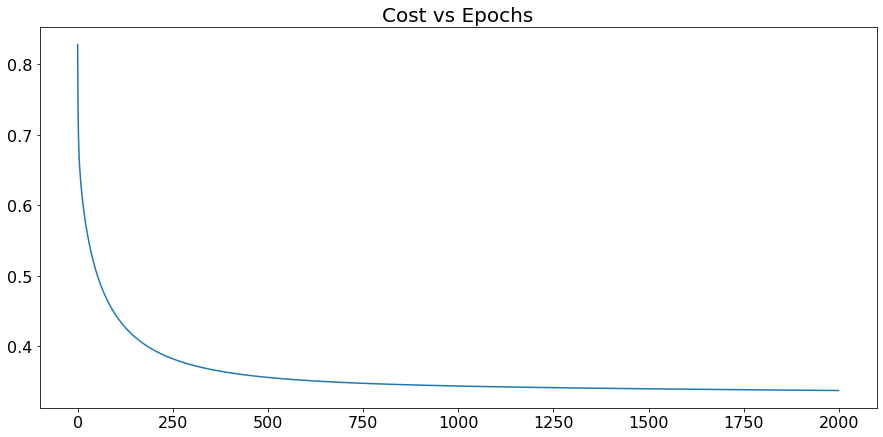

In [8]:
plt.figure(figsize=(15, 7))
pl.plot(best_cost_list, label='cost')
pl.title("Cost vs Epochs", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Vizualization of model predictions

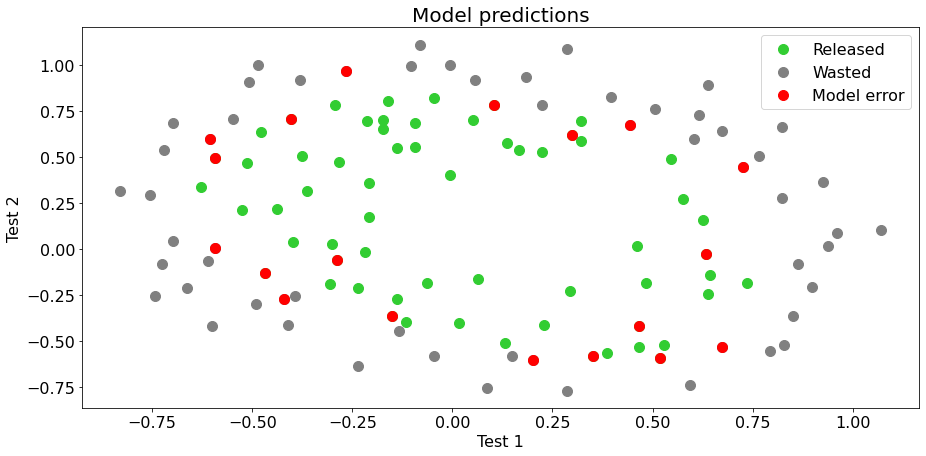

In [9]:
y_log_pred = classificator.predict(X_log_poly)

plt.figure(figsize=(15, 7))

plt.scatter(X_log[y_log_pred == 1, 0], X_log[y_log_pred == 1, 1], s=100, c='#32CD32', label='Released')
plt.scatter(X_log[y_log_pred == 0, 0], X_log[y_log_pred == 0, 1], s=100, c='grey', label='Wasted')
plt.scatter(X_log[y_log_pred != y_log, 0], X_log[y_log_pred != y_log, 1], s=100, c='red', label='Model error')

plt.xlabel("Test 1", fontsize=16)
plt.ylabel("Test 2", fontsize=16)
plt.title('Model predictions', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

plt.show()

Predictions don't look like overfitted, cost function falls, so that's alright!

# Time for Linear regressor

Reading dataset from https://www.kaggle.com/datasets/harinir/petrol-consumption

In [10]:
dataset = pd.read_csv('.data/petrol_consumption.csv')
features_columns = ['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)']
target_column = 'Petrol_Consumption'
X_lin = dataset[features_columns] 
y_lin = dataset[target_column]
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Petrol_tax                    48 non-null     float64
 1   Average_income                48 non-null     int64  
 2   Paved_Highways                48 non-null     int64  
 3   Population_Driver_licence(%)  48 non-null     float64
 4   Petrol_Consumption            48 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


Scaling data

In [11]:
scaler = StandardScaler()
scaler.fit(X_lin)
X_lin_scaled = scaler.transform(X_lin)
pd.DataFrame(X_lin_scaled, columns=features_columns).head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
0,1.415441,-1.181841,-1.038921,-0.825903
1,1.415441,-0.263969,-1.249055,0.030364
2,1.415441,-0.663887,-1.151803,0.176112
3,-0.178923,1.106673,-0.930381,-0.753029
4,0.352532,0.276889,-1.486106,-0.479753


Splitting data on features and targets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_lin_scaled, y_lin, test_size=0.2, random_state=0)

Checking Linear Regression works

In [13]:
regressor = LinLogRegression(X_train, y_train, mode='lin')
cost_list = regressor.fit(0.0001, 0.1, 2000)

Fine! Custom Grid Search is again

In [14]:
params = {'lr': [0.01, 0.001, 0.0001], 'theta': [0.1, 0.01, 0.001, 0.0001], 
          'epochs': [100, 500, 1000, 5000, 10000]}
best_score = 0
best_classificator = None
best_cost_list = None
for i in range(30):
    current_params = [random.choice(params[param]) for param in params.keys()]
    
    regressor = LinLogRegression(X_train, y_train, mode='lin')
    cost_list = regressor.fit(current_params[0], current_params[1], current_params[2])

    y_lin_pred = regressor.predict(X_test)
    MSE = metrics.mean_squared_error(y_test, y_lin_pred)
    
    if i == 0:
        best_score = MSE
    elif MSE < best_score:
        best_score = MSE
        best_params_lin = current_params
        best_regressor = regressor
        best_cost_list =  cost_list
        y_lin_pred_best = y_lin_pred

print(f"The lowest MSE is {round(best_score, 3)} with learning rate: {best_params_lin[0]}, \
thetha for L2-regularization: {best_params_lin[1]} and on {best_params_lin[2]} epochs")

The lowest MSE is 4630.833 with learning rate: 0.0001, thetha for L2-regularization: 0.1 and on 5000 epochs


Let's look at the result and trained weights

In [15]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_lin_pred_best, 'Difference': y_test-y_lin_pred_best}) 

,Actual,Predicted,Difference
29,534,469.794788,64.205212
4,410,545.017972,-135.017972
26,577,589.498969,-12.498969
30,571,569.252368,1.747632
32,577,649.642373,-72.642373
37,704,646.102805,57.897195
34,487,511.224216,-24.224216
40,587,671.818425,-84.818425
7,467,501.892297,-34.892297
10,580,501.454226,78.545774


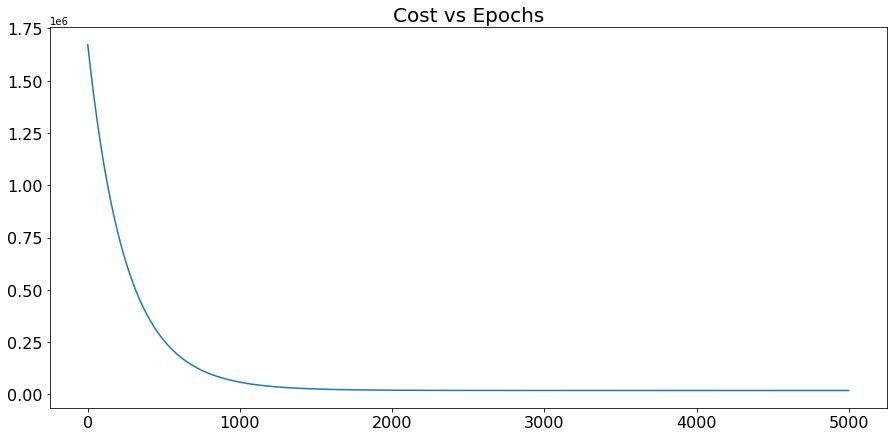

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(best_cost_list, label='cost')
plt.title("Cost vs Epochs", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [17]:
print(f'Bias is {best_regressor.get_weights()[1]}')
pd.DataFrame(best_regressor.get_weights()[0], index=features_columns, columns=['weights'])

Bias is 580.0538509781109


,weights
Petrol_tax,-37.081904
Average_income,-36.971652
Paved_Highways,-15.874806
Population_Driver_licence(%),73.617024


# And let's repeat everything on torch

In [20]:
class LinLogRegressionTorch(torch.nn.Module):
    """
    Class for both Linear and Logistic Regressions on TORCH. It's needed to choose mode - "lin" or "log".
    Linear Regression: multipule regressor with L2-regularization.
        Data: X - standart scaled torch.Tensor with shape (n_features, batch_size), 
              y - target torch.Tensor with shape (batch_size)
        Predict: REGRESSOR, float64
    LogistiC regression: binary classificator with L2-regularization.
        Data: X - torch.Tensor data with shape (1+n_features, batch_size), bias should be included, 
              y - torch.Tensor target with shape (batch_size)
        Predict: CLASSIFICATION, bool 
        
    """
    def __init__(self, input_dim, output_dim, mode=None):
        super(LinLogRegressionTorch, self).__init__()
        if mode:
            self.mode = mode
        else:
            raise ValueError('Choose "lin" or "log" mode')
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, X):
        if self.mode == 'lin':
            outputs = self.linear(X)
        else:
            outputs = torch.sigmoid(self.linear(X))
        return outputs
    
    def predict(self, X):
        with torch.no_grad():
            if self.mode == 'log':
                t = torch.Tensor([0.5]) # threshold
                outputs = (self.forward(X) > t).float() * 1
                return outputs
            else:
                return self.forward(X)

In [24]:
def train_torch(X, y, criterion, optimizer, epochs, mode=None):
    if not mode:
        raise ValueError('Choose "lin" or "log" mode')
    losses = []
    losses_test = []
    Iterations = []
    accuracies = []
    iter = 0
    for epoch in range(epochs):
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X)
        loss = criterion(torch.squeeze(outputs), y) 

        loss.backward() # Computes the gradient of the given tensor

        optimizer.step() # Updates weights and biases with the optimizer 
        
        iter+=1
        # calculate Accuracy
        with torch.no_grad():
            if mode=='log':
                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y.detach().numpy())
                accuracy = correct/total

                accuracies.append(accuracy)
                losses.append(loss.item())
                Iterations.append(iter)
            else:
                losses.append(loss.item())
                Iterations.append(iter)
                    
    return losses, accuracies, Iterations

Logistic regression on torch

In [27]:
epochs = 10000

poly = PolynomialFeatures(degree=8)
X_log_poly = poly.fit_transform(X_log)
X_log_poly, y_log = torch.Tensor(X_log_poly), torch.Tensor(y_log)

input_dim = X_log_poly.shape[1]
output_dim = 1

model = LinLogRegressionTorch(input_dim, output_dim, mode='log')
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

losses, accuracies, Iterations = train_torch(X_log_poly, y_log, criterion, optimizer, epochs, mode='log')


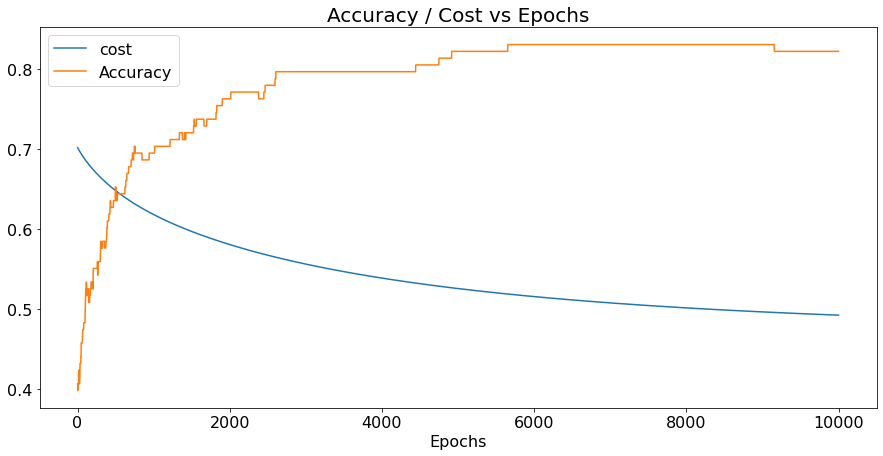

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(Iterations, losses, label='cost')
plt.plot(Iterations,  accuracies, label='Accuracy')
plt.title("Accuracy / Cost vs Epochs", fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.show()

Let's vizualize model's errors

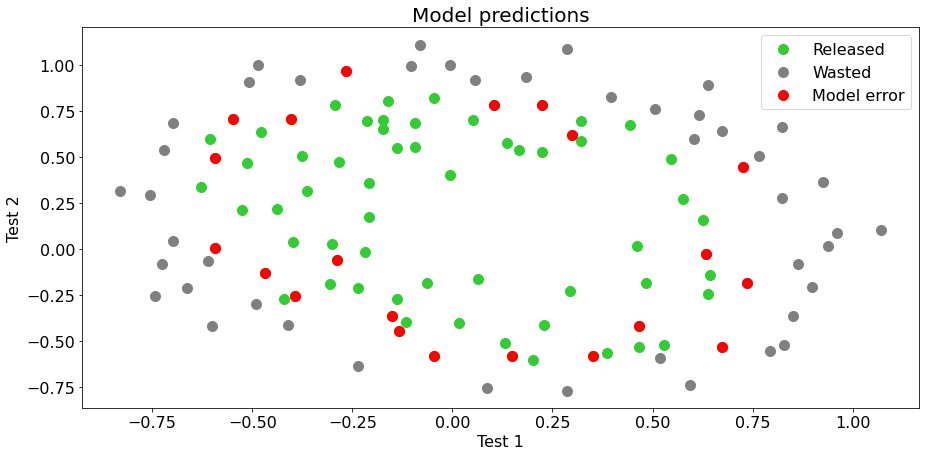

In [29]:
y_log_pred = np.reshape(model.predict(X_log_poly), (y_log_pred.shape[0],))

plt.figure(figsize=(15, 7))

plt.scatter(X_log[y_log_pred == 1, 0], X_log[y_log_pred == 1, 1], s=100, c='#32CD32', label='Released')
plt.scatter(X_log[y_log_pred == 0, 0], X_log[y_log_pred == 0, 1], s=100, c='grey', label='Wasted')
plt.scatter(X_log[y_log_pred != y_log, 0], X_log[y_log_pred != y_log, 1], s=100, c='red', label='Model error')

plt.xlabel("Test 1", fontsize=16)
plt.ylabel("Test 2", fontsize=16)
plt.title('Model predictions', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

plt.show()

It looks the same with manual realization. Let's realize Linear regression on torch

In [30]:
epochs = 5000

X_lin_scaled, y_lin = torch.Tensor(X_lin_scaled), torch.Tensor(y_lin)

input_dim = X_lin_scaled.shape[1]
output_dim = 1

model = LinLogRegressionTorch(input_dim, output_dim, mode='lin')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

losses, _, Iterations = train_torch(X_lin_scaled, y_lin, criterion, optimizer, epochs, mode='lin')

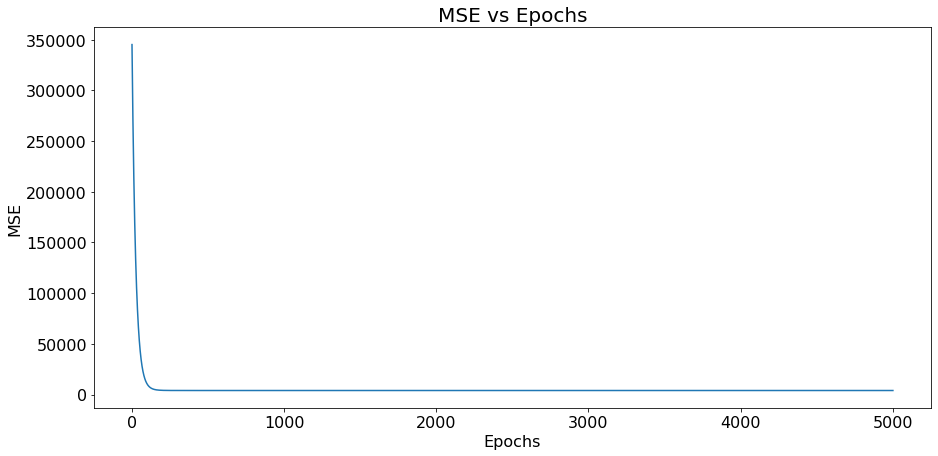

In [31]:
plt.figure(figsize=(15, 7))
plt.plot(Iterations, losses, label='cost')
plt.title("MSE vs Epochs", fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [44]:
y_lin_pred_torch = torch.reshape(model.predict(torch.Tensor(X_test)), (y_test.shape[0],))
pd.DataFrame({'Actual': torch.Tensor(np.array(y_test)), 'Predicted': y_lin_pred_torch, 'Difference': torch.Tensor(np.array(y_test)) - y_lin_pred_torch}) 

,Actual,Predicted,Difference
0,534.0,469.463135,64.536865
1,410.0,529.369019,-119.369019
2,577.0,585.614319,-8.614319
3,571.0,564.103455,6.896545
4,577.0,648.256287,-71.256287
5,704.0,638.764099,65.235901
6,487.0,503.814941,-16.814941
7,587.0,659.639832,-72.639832
8,467.0,489.118256,-22.118256
9,580.0,497.992249,82.007751


In [64]:
y_lin_pred_torch = np.reshape(model.predict(torch.Tensor(X_test)), (y_test.shape[0],))
MSE = metrics.mean_squared_error(torch.Tensor(np.array(y_test)), y_lin_pred_torch)
print(f'Mean squared error for Linear Regression on torch is {MSE}')

Mean squared error for Linear Regression on torch is 4064.26953125


In [59]:
print(f'Bias is {float(model.linear.bias.detach()[0])}')
pd.DataFrame([float(i) for i in model.linear.weight.detach()[0]], index=features_columns, columns=['weights'])


Bias is 573.8998413085938


,weights
Petrol_tax,-32.657585
Average_income,-37.552555
Paved_Highways,-8.337888
Population_Driver_licence(%),72.977409
